In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [13]:
# ----------------------------------------------------------
# 1. LOAD DATA (Change CSV name if needed)
# ----------------------------------------------------------
csv_path = "./archive/census2011.csv"    # update if needed
df = pd.read_csv(csv_path)

# Clean numeric columns
df['Growth'] = df['Growth'].astype(str).str.replace('%','').astype(float)
df['Population'] = df['Population'].astype(str).str.replace(',','').astype(float)
df['Literacy'] = df['Literacy'].astype(float)
df['Sex-Ratio'] = df['Sex-Ratio'].astype(float)

In [14]:
df.head

<bound method NDFrame.head of      Ranking                    District                        State  \
0          1                       Thane                  Maharashtra   
1          2  North Twenty Four Parganas                  West Bengal   
2          3                   Bangalore                    Karnataka   
3          4                        Pune                  Maharashtra   
4          5             Mumbai Suburban                  Maharashtra   
..       ...                         ...                          ...   
605      636                    Nicobars  Andaman and Nicobar Islands   
606      637                 Upper Siang            Arunachal Pradesh   
607      638             Lahul and Spiti             Himachal Pradesh   
608      639                       Anjaw            Arunachal Pradesh   
609      640               Dibang Valley            Arunachal Pradesh   

     Population  Growth  Sex-Ratio  Literacy  
0    11060148.0   36.01      886.0     84.53  

In [15]:
# ----------------------------------------------------------
# 2. AGGREGATE DATA TO STATE LEVEL (since clustering is on states)
# ----------------------------------------------------------
state_df = df.groupby("State").agg({
    "Population": "sum",
    "Growth": "mean",
    "Literacy": "mean",
    "Sex-Ratio": "mean"
}).reset_index()

print("States:", len(state_df))
print(state_df.head())

States: 35
                         State  Population     Growth   Literacy   Sex-Ratio
0  Andaman and Nicobar Islands    380581.0   0.596667  83.700000  857.666667
1               Andhra Pradesh  67459740.0  11.214118  67.034118  993.705882
2            Arunachal Pradesh   1383727.0  27.805625  63.861875  919.812500
3                        Assam  28381808.0  16.313077  72.242692  957.384615
4                        Bihar  89751364.0  25.403636  61.244545  919.363636


In [16]:
# ----------------------------------------------------------
# 3. SELECT FEATURES FOR CLUSTERING
# ----------------------------------------------------------
features = ["Population", "Growth", "Literacy", "Sex-Ratio"]
X = state_df[features].values

# Normalize (important for K-Means)
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1
X_norm = (X - X_mean) / X_std

In [17]:
# ----------------------------------------------------------
# 4. K-Means FROM SCRATCH
# ----------------------------------------------------------
class KMeansScratch:
    
    def __init__(self, k, max_iters=100):
        self.k = k
        self.max_iters = max_iters
        self.centroids = None
        self.history_centroids = []
    
    def initialize_centroids(self, X):
        idx = np.random.choice(len(X), self.k, replace=False)
        return X[idx]
    
    def compute_distances(self, X, centroids):
        return np.sqrt(((X[:, None, :] - centroids[None, :, :]) ** 2).sum(axis=2))
    
    def compute_wcss(self, X, labels, centroids):
        wcss = 0
        for i in range(self.k):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                wcss += ((cluster_points - centroids[i])**2).sum()
        return wcss
    
    def fit(self, X):
        self.centroids = self.initialize_centroids(X)
        
        for _ in range(self.max_iters):
            # save centroids for evolution visualization
            self.history_centroids.append(self.centroids.copy())
            
            # Step 1: assign clusters
            distances = self.compute_distances(X, self.centroids)
            labels = np.argmin(distances, axis=1)
            
            # Step 2: recompute centroids
            new_centroids = []
            for i in range(self.k):
                points = X[labels == i]
                if len(points) > 0:
                    new_centroids.append(points.mean(axis=0))
                else:
                    new_centroids.append(self.centroids[i])  # unchanged if empty
            new_centroids = np.array(new_centroids)
            
            # Check convergence
            if np.allclose(self.centroids, new_centroids):
                break
            
            self.centroids = new_centroids
        
        self.labels_ = labels
        self.wcss_ = self.compute_wcss(X, labels, self.centroids)
        return self



In [18]:
# ----------------------------------------------------------
# 5. RUN EXPERIMENTS FOR k = 3,4,5 AND COMPUTE WCSS
# ----------------------------------------------------------
K_values = [3, 4, 5]
results = {}

for k in K_values:
    print(f"\nRunning K-Means for k={k}")
    model = KMeansScratch(k=k, max_iters=100)
    model.fit(X_norm)
    results[k] = model
    print("WCSS =", model.wcss_)


Running K-Means for k=3
WCSS = 78.62451488646707

Running K-Means for k=4
WCSS = 59.244911918358916

Running K-Means for k=5
WCSS = 45.84711896011592


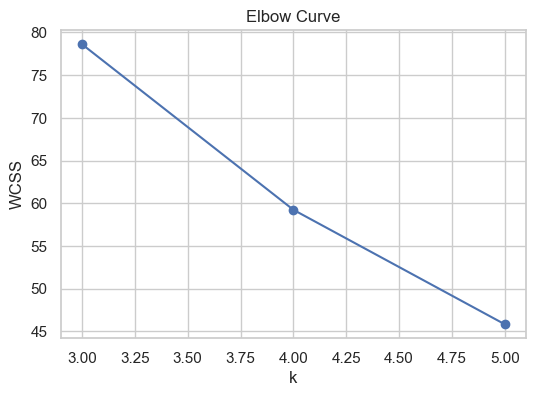

In [19]:
# ----------------------------------------------------------
# 6. PLOT ELBOW CURVE
# ----------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(K_values, [results[k].wcss_ for k in K_values], marker='o')
plt.xlabel("k")
plt.ylabel("WCSS")
plt.title("Elbow Curve")
plt.show()

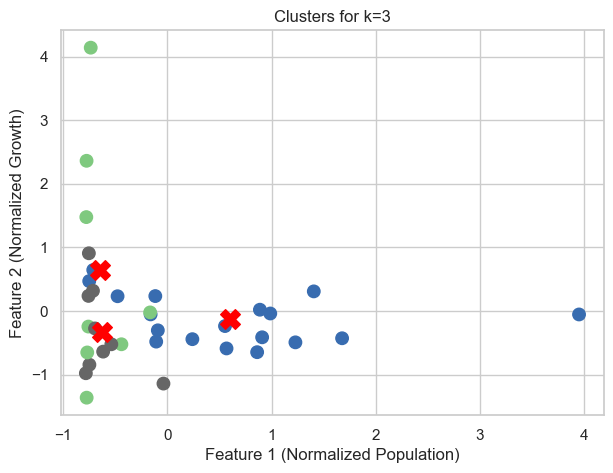

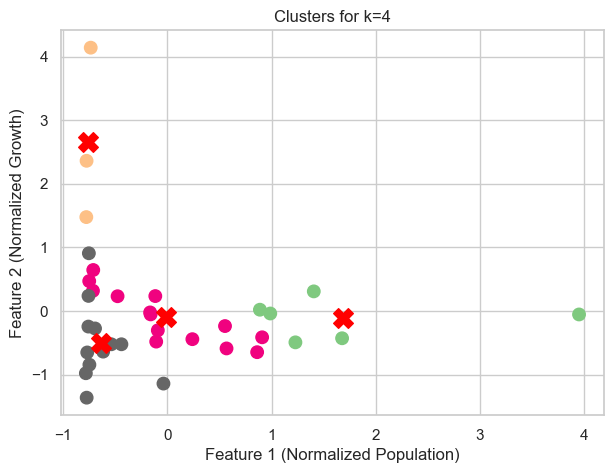

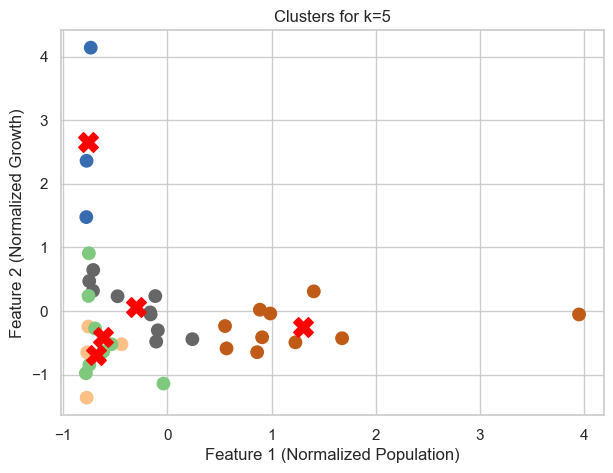

In [20]:

# ----------------------------------------------------------
# 7. VISUALIZE CLUSTERS (using 2D projections)
# We use PCA-like manual projection: first 2 columns after normalization
# ----------------------------------------------------------
def plot_clusters(model, title):
    labels = model.labels_
    plt.figure(figsize=(7,5))
    
    plt.scatter(X_norm[:,0], X_norm[:,1], c=labels, cmap="Accent", s=80)
    
    # plot centroids
    centroids = model.centroids
    plt.scatter(centroids[:,0], centroids[:,1], c="red", s=200, marker="X")
    
    plt.xlabel("Feature 1 (Normalized Population)")
    plt.ylabel("Feature 2 (Normalized Growth)")
    plt.title(title)
    plt.show()

for k in K_values:
    plot_clusters(results[k], f"Clusters for k={k}")

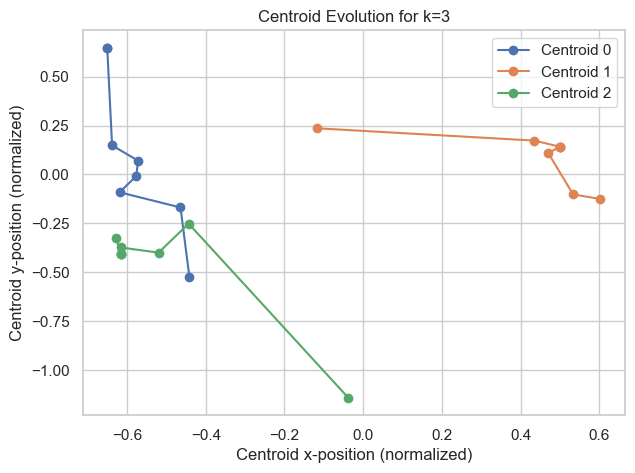

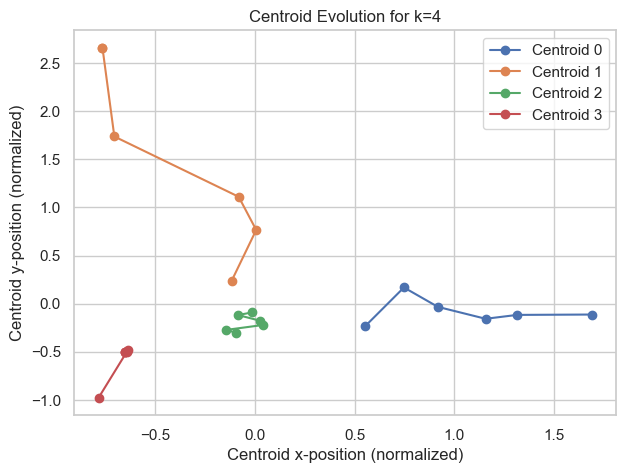

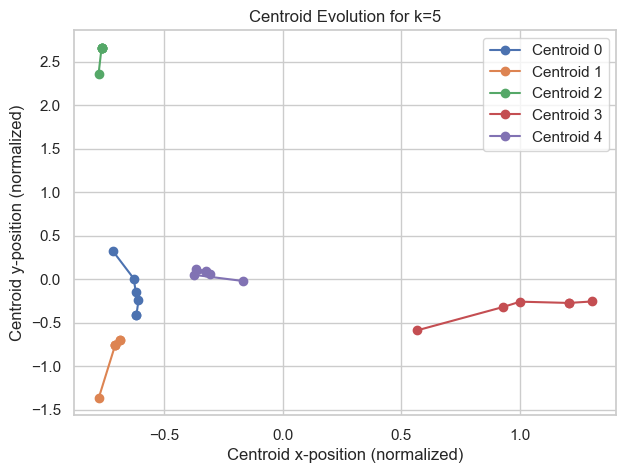

In [21]:

# ----------------------------------------------------------
# 8. VISUALIZE CENTROID EVOLUTION
# ----------------------------------------------------------
def plot_centroid_evolution(model, k):
    plt.figure(figsize=(7,5))
    
    for cluster_id in range(k):
        xs = [c[cluster_id][0] for c in model.history_centroids]
        ys = [c[cluster_id][1] for c in model.history_centroids]
        plt.plot(xs, ys, marker='o', label=f"Centroid {cluster_id}")
    
    plt.xlabel("Centroid x-position (normalized)")
    plt.ylabel("Centroid y-position (normalized)")
    plt.title(f"Centroid Evolution for k={k}")
    plt.legend()
    plt.show()

for k in K_values:
    plot_centroid_evolution(results[k], k)

In [22]:
# ----------------------------------------------------------
# 9. CLUSTER INTERPRETATION
# ----------------------------------------------------------
def analyze_clusters(model, k):
    print(f"\n===== Cluster Interpretation for k={k} =====")
    labels = model.labels_
    state_df["Cluster"] = labels
    
    for i in range(k):
        cluster_states = state_df[state_df["Cluster"] == i]
        print(f"\n--- Cluster {i} ---")
        print(f"States: {list(cluster_states['State'])}")
        print("Mean Values:")
        print(cluster_states[features].mean())
        
for k in K_values:
    analyze_clusters(results[k], k)



===== Cluster Interpretation for k=3 =====

--- Cluster 0 ---
States: ['Andaman and Nicobar Islands', 'Chandigarh', 'Dadra and Nagar Haveli', 'Daman and Diu', 'Delhi', 'Haryana', 'Nagaland', 'Sikkim']
Mean Values:
Population    5.502442e+06
Growth        3.042374e+01
Literacy      8.152917e+01
Sex-Ratio     8.483164e+02
dtype: float64

--- Cluster 1 ---
States: ['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chhattisgarh', 'Gujarat', 'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Madhya Pradesh', 'Maharashtra', 'Meghalaya', 'Orissa', 'Punjab', 'Rajasthan', 'Tamil Nadu', 'Uttar Pradesh', 'West Bengal']
Mean Values:
Population    5.686094e+07
Growth        1.895101e+01
Literacy      7.025170e+01
Sex-Ratio     9.488362e+02
dtype: float64

--- Cluster 2 ---
States: ['Goa', 'Himachal Pradesh', 'Kerala', 'Lakshadweep', 'Manipur', 'Mizoram', 'Puducherry', 'Tripura', 'Uttarakhand']
Mean Values:
Population    6.438323e+06
Growth        1.597857e+01
Literacy      8.618601e+01
Sex-Ra